### Attention mechanism in Image Classification using GradCAM <br>

When we give an image to a CNN for classification, how do we know visually that what part of the image it is actually looking at? And how is the network classifying the image, are there some salient features for a specific class that the network pays attention to? <br>
We can see this phenomenon using GradCAM algorithm, which shows which part of the feature map, the CNN is giving importance for classification. <br>

The image below is a demonstration of how a classification algorithm gives imortance to the most prominent features for classifying that object. <br>

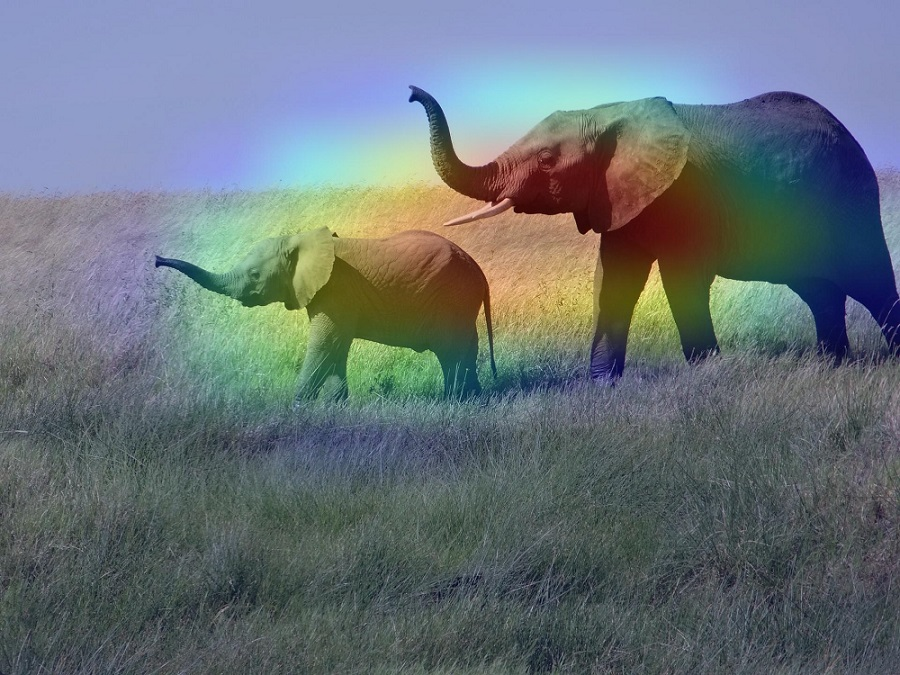


**How does GradCAM work?** <br>

This is nicely summarized by Chris in [this](https://www.machinecurve.com/index.php/2019/11/28/visualizing-keras-cnn-attention-grad-cam-class-activation-maps/) blog post which is as follows: <br>
* First, the gradient of the output class prediction with respect to the feature maps of your last convolutional layer is computed.

* Subsequently, these gradients flow back, and determine the relative importance of these feature maps for the class prediction, by means of global average pooling.

* By generating a weighted combination of the feature maps in this layer and their weights, we get a gradient-weighted CAM heatmap that represents both the positive and negative importance factors for the input image. The positive factors mean that many feature maps participate in the importance of some area with respect to the output class (i.e., the desired class). Those are the areas that likely contain the object of interest. The negative factors mean that many feature maps participate in the importance of that area with respect to the other classes (as the gradients will be strongly negative).

* Pass the heatmap through a ReLU function to filter out the negative areas, setting them to zero importance, while maintaining importance of the positive areas.

This allows us to visualize which part of the image is given importance in classifying the specific class.

Let's see this task in keras. We will use VGG16 for classifying an image and then use the model's last classifier layers to predict feature maps and find gradient.

In [1]:
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import decode_predictions

import numpy as np
from numpy import expand_dims
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
cd drive/MyDrive/Computer\ Vision\ CS-867\ TAship/notebooks

/content/drive/MyDrive/Computer Vision CS-867 TAship/notebooks


In [3]:
# load the model with pretrained weights on ImageNet 
model = VGG16()

In [4]:
# print model's summary to see layer names
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
# separate the classifier layer names in a list
classifier_layer_names = ['block5_pool', 'flatten', 'fc1', 'fc2', 
                          'predictions']

In [6]:
# load the image and preprocess it
img = load_img('elephant.png', target_size=(224, 224))
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)

In [7]:
# get the last conv layer
last_conv_layer = model.get_layer('block5_conv3')

# new model that outputs last conv layer's feature map
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [8]:
# We create a model that maps the activations of the last conv
# layer to the final class predictions

classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [9]:
# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer

with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [10]:
# This is the gradient of the top predicted class with regard to
# the output feature map of the last conv layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

[('n02504013', 'Indian_elephant', 0.867541)]


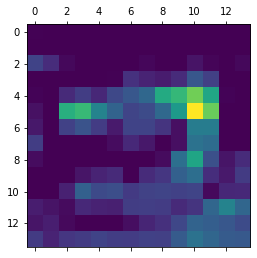

In [11]:
# print top class prediction
print(decode_predictions(model.predict(img), top=1)[0])

# Display heatmap
plt.matshow(heatmap)
plt.show()

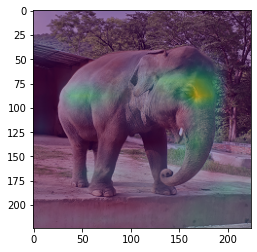

In [12]:
# load original image
orig_img = keras.preprocessing.image.load_img('elephant.png')

# upsample the heatmap
upsample = resize(heatmap, (224,224),preserve_range=True)

# show the heatmap overlayed on original image
plt.imshow(orig_img)
plt.imshow(upsample,alpha=0.5)
plt.show()

So we can see that model focuses on the eye region more on this image. You can try with different images and see the result. <br> <br>

*References:* <br>

[Grad-CAM class activation visualization](https://keras.io/examples/vision/grad_cam/) <br>

[Demystifying CNNs using GradCAM](https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-gradcam-554a85dd4e48)